# A modest proposal for dataset

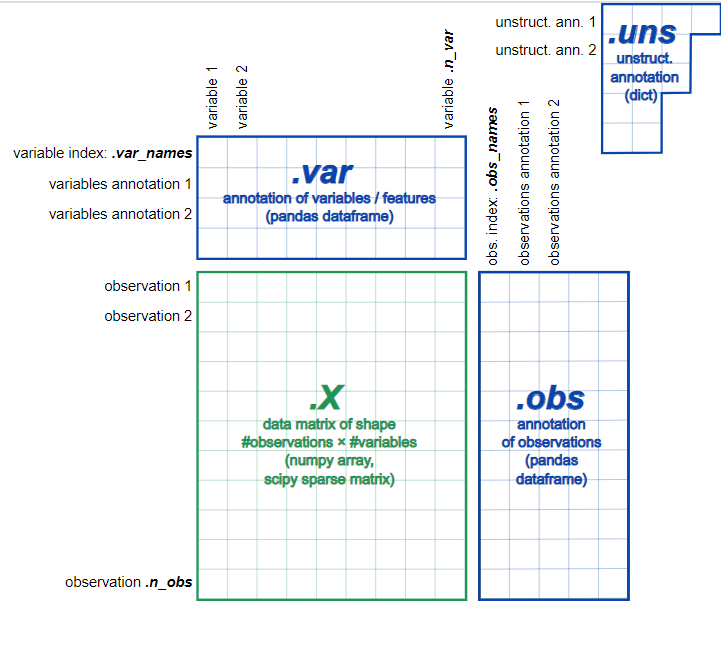

## Imports

In [4]:
import pinot
import numpy as np
import pandas as pd

## Munging and flattening stuff.

In [5]:
ds = pinot.data.moonshot_mixed()

# flatten cs and ys
for idx, d in enumerate(ds.ds):
    d['cs'] = []
    d['ys'] = []
    
    if isinstance(d['cs_multiple'], list):
        d['cs'].extend(d['cs_multiple'])
        d['ys'].extend(d['ys_multiple'])
    
    d['cs'].extend(d['cs_single'])
    d['ys'].extend(d['ys_single'])
    
    del d['cs_multiple']
    del d['ys_multiple']
    del d['cs_single']
    del d['ys_single']
    
# gather cs and ys into dictionary
cs = [d['cs'] for d in ds]
ys = [d['ys'] for d in ds]
ys_dicts =  [dict(zip(d['cs'], d['ys'])) for d in ds]

Preparing to create combined dataframe.

In [16]:
# first, get all concentrations
unique = lambda array: set(x for l in array for x in l)
concentrations = sorted(list(unique(cs)))

# for each concentration, check if it is in cs
datalist = []
for idx, ys_dict in enumerate(ys_dicts):
    
    # create row of dataframe
    row_y = []
    for concentration in concentrations:
        if concentration in ys_dict:
            # if it is, add it to the row
            row_y.append(ys_dict[concentration])
        else:
            # else, add a dummy value
            row_y.append(np.nan)
    
    # append row to dataframe
    datalist.append(row_y)

## Creating AnnData object.

In [71]:
# create dataframe
df = pd.DataFrame(datalist, columns=concentrations)
df.index = [str(i) for i in df.index]
df.index.name = 'compound'
df.columns = [str(c) for c in df.columns]
df.columns.name = 'concentration'

# create AnnData object
import anndata as ad
adata = ad.AnnData(df)

Fill metadata.

In [72]:
# add observation metadata
adata.obs['SMILES'] = [d['SMILES'] for d in ds]
adata.obs['graph'] = [d['g'] for d in ds]

# add data-level metadata
adata.layers['measurement'] = adata.X

# for example, replicate annotation
replicate_annotations = np.random.choice([0., 1.], adata.shape)
replicate_annotations[np.isnan(adata.X)] = np.nan
adata.layers['replicate'] = replicate_annotations

# could add dataset-level information
adata.uns['n_measurements'] = (~np.isnan(adata.X)).sum()
adata.uns['n_unique_graphs'] = len(adata.obs)

In [73]:
adata

AnnData object with n_obs × n_vars = 785 × 39
    obs: 'SMILES', 'graph'
    uns: 'n_measurements', 'n_unique_graphs'
    layers: 'measurement', 'replicate'

In [74]:
adata.obs

,SMILES,graph
compound,,
0,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1,"DGLGraph(num_nodes=19, num_edges=40,\n ..."
1,COc1ccc(NC(=O)c2ccc(C(=N)N(C)C)cc2)c(C(=O)Nc2c...,"DGLGraph(num_nodes=32, num_edges=68,\n ..."
2,Nc1cc(C(F)(F)F)c(-c2nc(N3CCOCC3)nc(N3CCOCC3)n2...,"DGLGraph(num_nodes=29, num_edges=64,\n ..."
3,C[C@@H]1COCCN1c1cc(C2([S@](C)(=N)=O)CC2)nc(-c2...,"DGLGraph(num_nodes=29, num_edges=66,\n ..."
4,C[C@@H](Cn1ccc(-c2ccc(C#N)c(Cl)c2)n1)NC(=O)c1c...,"DGLGraph(num_nodes=28, num_edges=60,\n ..."
...,...,...
780,O=C(Nc1cccnc1)Nc1ccc(Cl)s1,"DGLGraph(num_nodes=16, num_edges=34,\n ..."
781,Cc1coc(NC(=O)Nc2cccnc2)n1,"DGLGraph(num_nodes=16, num_edges=34,\n ..."
782,O=C(Cc1ccc(Cl)s1)Nc1cccnc1,"DGLGraph(num_nodes=16, num_edges=34,\n ..."


# Mini-batches demo

Setting up a loader.

In [79]:
# adding requisite columns
a_df = adata.to_df()
a_df['compound'] = range(len(a_df))
a_df['graph'] = adata.obs['graph']

# melting to long format
df_loader_unfiltered = pd.melt(a_df, id_vars=['compound', 'graph'])
df_loader = df_loader_unfiltered[~np.isnan(df_loader_unfiltered['value'])]
df_loader.columns = ['id', 'g', 'c', 'y']

In [82]:
df_loader

,id,g,c,y
22,22,"DGLGraph(num_nodes=27, num_edges=58,\n ...",0.02,6.278152
23,23,"DGLGraph(num_nodes=16, num_edges=32,\n ...",0.02,1.340155
29,29,"DGLGraph(num_nodes=35, num_edges=74,\n ...",0.02,-5.929080
30,30,"DGLGraph(num_nodes=35, num_edges=74,\n ...",0.02,-2.419920
31,31,"DGLGraph(num_nodes=35, num_edges=74,\n ...",0.02,-7.149176
...,...,...,...,...
30085,255,"DGLGraph(num_nodes=20, num_edges=42,\n ...",99.5,49.565392
30206,376,"DGLGraph(num_nodes=23, num_edges=50,\n ...",99.5,89.303780
30207,377,"DGLGraph(num_nodes=23, num_edges=50,\n ...",99.5,95.977257
30389,559,"DGLGraph(num_nodes=20, num_edges=44,\n ...",99.5,65.462982


Iterating.

In [81]:
for batch in df_loader.itertuples(index=False):
    print(batch.g)
    print(batch.c)
    print(batch.y)
    break

DGLGraph(num_nodes=27, num_edges=58,
         ndata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32), 'h': Scheme(shape=(117,), dtype=torch.float32)}
         edata_schemes={'type': Scheme(shape=(), dtype=torch.float32)})
0.02
6.278151988983154


Note that `itertuples` is actually slow for iteration purposes. This is just to demonstrate the idea.